# implementation of the SNN algorithm

In [298]:
from numpy.linalg import norm
from time import time
%matplotlib inline

import numpy as np
from scipy.stats import norm as norms

import ot

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
### Quasi-random sequences
from sobol_seq import i4_sobol_generate

### Kernel SoS OT functions
from utils import make_kernels, transport_1D, potential_1D

In [20]:
def kernel_cost(gamma, data, reg):

    KX2 = data['KX2']
    KY2 = data['KY2']
    KX3 = data['KX3']
    KY3 = data['KY3']

    tmp1 = np.mean(KX3) + np.mean(KY3)
    tmp2 = (np.mean(KX2, axis=0) + np.mean(KY2, axis=0)) @ gamma
    c = (tmp1 - tmp2) / (2 * reg)

    return c

In [300]:
def gradient(gamma, X, Phi, Q, z, reg1, reg2):
    """
    Compute the gradient of the objective function.

    Args:
        gamma (np.ndarray): m*1 vector.
        X (np.ndarray): m*m matrix.
        Phi (np.ndarray): m*m matrix.
        Q (np.ndarray): m*m matrix.
        z (np.ndarray): m*1 vector.
        reg1 (float): Regularization parameter.
        reg2 (float): Regularization parameter.

    Returns:
        g_gamma (np.ndarray): m*1 vector.
        g_X (np.ndarray): m*m matrix.
    """
    m = len(z)
    H = Phi.T @ X @ Phi
    g_gamma = (Q @ gamma - z) / (2 * reg2) - np.diag(H)
    g_X = Phi @ np.diag(gamma) @ Phi.T + reg1 * np.eye(m)
    return g_gamma, g_X


In [301]:
def residue(gamma, X, Phi, Q, z, reg1, reg2):
    """
    Compute the residue of the objective function.

    Args:
        gamma (np.ndarray): m*1 vector.
        X (np.ndarray): m*m matrix.
        Phi (np.ndarray): m*m matrix.
        Q (np.ndarray): m*m matrix.
        z (np.ndarray): m*1 vector.
        reg1 (float): Regularization parameter.
        reg2 (float): Regularization parameter

    Returns:
        r_gamma (np.ndarray): m*1 vector
        r_X (np.ndarray): m*m matrix.
    """
    # Compute the gradient
    g_gamma, g_X = gradient(gamma, X, Phi, Q, z, reg1, reg2)  
    X_new = X - g_X
    V, D = np.linalg.eigh(X_new)
    X_new = V @ np.maximum(D, 0) @ V.T
    r_X = X - X_new
    
    return g_gamma, r_X


### a) implementation of SSN step

In [302]:

def SSN_main(r_gamma, r_X, gamma, X, mu, Q, Phi, reg1, reg2):
    m = len(gamma)

    # The first step
    Z = X - (Phi @ np.diag(gamma) @ Phi.T + reg1 * np.eye(m))
    Sigma, P_ = np.linalg.eigh(Z)
    Sigma = Sigma[::-1]
    P_ = P_[:, ::-1]
    alpha = np.where(Sigma > 0)[0]
    beta = np.where(Sigma <= 0)[0]
    Omega = np.zeros((m, m))
    Omega[np.ix_(alpha, alpha)] = np.ones(len(alpha))
    eta = 1 - np.outer(Sigma[beta], 1/Sigma[alpha])
    eta = 1 / eta
    Omega[np.ix_(alpha, beta)] = eta.T
    Omega[np.ix_(beta, alpha)] = eta
    L = Omega / (mu + 1 - Omega)

    T = r_X + P_ @ (L * (P_.T @ r_X @ P_)) @ P_.T
    H = Phi.T @ T @ Phi
    d_gamma = - r_gamma - np.diag(H) / (1 + mu)
    d_X = -r_X

    # The second step (CG)
    y = d_gamma
    K = P_.T @ Phi
    H = K.T @ (L * (K @ np.diag(y) @ K.T)) @ K
    r = d_gamma - ((0.5 / reg2) * Q @ y + mu * y + np.diag(H))
    p = r
    rr = r.T @ r
    for _ in range(min(m // 5, 50)):
        H = K.T @ (L * (K @ np.diag(p) @ K.T)) @ K
        Ap = (0.5 / reg2) * Q @ p + mu * p + np.diag(H)
        ss1 = rr / (p.T @ Ap)
        y += ss1 * p
        r -= ss1 * Ap
        if np.linalg.norm(r) < 1e-6:
            break
        ss2 = r.T @ r / rr
        p = r + ss2 * p
        H = K.T @ (L * (K @ np.diag(y) @ K.T)) @ K
        r = d_gamma - ((0.5 / reg2) * Q @ y + mu * y + np.diag(H))
        rr = r.T @ r
    d_gamma = y
    d_X = (d_X + P_ @ (L * (P_.T @ d_X @ P_)) @ P_.T) / (1 + mu)

    # The third step
    d_X -= P_ @ (L * (K @ np.diag(d_gamma) @ K.T)) @ P_.T

    return d_gamma, d_X


### b) implementation of SSN algorithm

In [319]:
def SSN(data, alph_1, alph_2, beta_0, beta_1, beta_2, theta_upper,
        theta_lower, reg1, reg2, EG_rate, nIter, verbose):

    """
    Solve the conic optimization model using a semi-smooth Newton method.

    Input:
    - data: dict, contient les données nécessaires pour le modèle
    - reg1: float, régularisation 1
    - reg2: float, régularisation 2
    - verbose: bool, indique si les détails doivent être imprimés

    Output:
    - gamma: array, vecteur de taille m
    - c: float, coût
    - t: float, temps de résolution
    - res_time: list, historique du temps de résolution
    - res_norm: list, historique de la norme du résidu
    """
    # Input data
    M = data['M']
    Phi = data['Phi']
    KX1 = data['KX1']
    KY1 = data['KY1']
    KX2 = data['KX2']
    KY2 = data['KY2']

    # Initialization
    m = len(M)
    Q = KX1 + KY1
    z = np.mean(KX2, axis=0) + np.mean(KY2, axis=0) - 2 * reg2 * M

    gamma = np.ones(m) /m
    v_gamma = gamma 
    X = np.ones((m, m)) /(m*m)
    v_X = X
    theta = 1.0    
    r_gamma, r_X = residue(gamma, X, Phi, Q, z, reg1, reg2)
    mu = theta * (norm(r_gamma) + norm(r_X, 'fro'))
    res_time = [0]
    res_norm = [mu]

    if verbose:
        print('\n-------------- SSNEG ---------------')
        print('iter |  cost  |  residue  |  time')
    
    tstart = time()
   
    usage_lst=[(0,0)]
    details=[]
    nb_EG_iter = 0
    # Main loop
    for iter in range(1, nIter + 1):

        # Compute EG step
        g_gamma, g_x = gradient(v_gamma, v_X, Phi, Q, z, reg1, reg2)
        v_gamma_mid = v_gamma - EG_rate * g_gamma
        v_X_mid = v_X - EG_rate * g_x
        g_gamma, g_x = gradient(v_gamma_mid, v_X_mid, Phi, Q, z, reg1, reg2)
        v_gamma = v_gamma - EG_rate * g_gamma
        v_X = v_X - EG_rate * g_x


        # Compute the residue function
        mu = norm(r_gamma) + norm(r_X, 'fro')

        # Compute SSN step
        d_gamma, d_X = SSN_main(r_gamma, r_X, gamma, X,  (m / 5) * theta * mu, Q, Phi, reg1, reg2)

        
        # Compute the next iterate
        r_gamma_, r_X_ = residue(gamma + d_gamma, X + d_X, Phi, Q, z, reg1, reg2)
        r_gamma_v, r_X_v = residue(v_gamma, v_X, Phi, Q, z, reg1, reg2)
        if (norm(r_gamma_) + norm(r_X_, 'fro')) < (norm(r_gamma_v) + norm(r_X_v, 'fro')):
            gamma += d_gamma
            X += d_X
        else:
            gamma = v_gamma
            X = v_X
            nb_EG_iter += 1
        
        # Update the parameter theta
        r_gamma, r_X = residue(gamma, X, Phi, Q, z, reg1, reg2)
        rho_div_norm = -(np.dot(r_gamma, d_gamma) + np.trace(np.dot(r_X.T, d_X))) / (norm(d_gamma) ** 2 + norm(d_X, 'fro') ** 2)
        if rho_div_norm >= alph_2:
            theta = max(beta_0 * theta, theta_lower)
        elif rho_div_norm >= alph_1:
            theta = beta_1 * theta
        else:
            theta  = min(theta_upper, beta_2 * theta)
        
        if mu < 5e-3:  # 5e-3
            c = kernel_cost(gamma, data, reg2)
            t = time() - tstart
            res_time.append(t)
            res_norm.append(mu)
            if verbose:
                print(f'{iter:5}|{c:3.2e}|{mu:3.2e}|{t:3.2e}')
            break

        if iter % 100 == 0:
            c = kernel_cost(gamma, data, reg2)
            t = time() - tstart
            res_time.append(t)
            res_norm.append(mu)
            if verbose:
                print(f'{iter:5}|{c:3.2e}|{mu:3.2e}|{t:3.2e}')
        
        
        c = kernel_cost(gamma, data, reg2)
        t = time() - tstart

    return gamma, c, t, res_time, res_norm, usage_lst, details, nb_EG_iter 

#### c) Implementation of EG algorithm for comparison purpose

In [306]:
def EG(data, reg1, reg2, EG_rate, nIter, verbose):

    """
    Solve the conic optimization model using a semi-smooth Newton method.

    Input:
    - data: dict, contient les données nécessaires pour le modèle
    - reg1: float, régularisation 1
    - reg2: float, régularisation 2
    - verbose: bool, indique si les détails doivent être imprimés

    Output:
    - gamma: array, vecteur de taille m
    - c: float, coût
    - t: float, temps de résolution
    - res_time: list, historique du temps de résolution
    - res_norm: list, historique de la norme du résidu
    """
    # Input data
    M = data['M']
    Phi = data['Phi']
    KX1 = data['KX1']
    KY1 = data['KY1']
    KX2 = data['KX2']
    KY2 = data['KY2']

    # Initialization
    m = len(M)
    Q = KX1 + KY1
    z = np.mean(KX2, axis=0) + np.mean(KY2, axis=0) - 2 * reg2 * M

    gamma = np.ones(m) /m
    X = np.ones((m, m)) /(m*m)
    theta = 1.0    
    r_gamma, r_X = residue(gamma, X, Phi, Q, z, reg1, reg2)
    mu = theta * (norm(r_gamma) + norm(r_X, 'fro'))
    res_time = [0]
    res_norm = [mu]

    if verbose:
        print('\n-------------- SSNEG ---------------')
        print('iter |  cost  |  residue  |  time')
    
    tstart = time()
   
    usage_lst=[(0,0)]
    details=[]
    # Main loop
    for iter in range(1, nIter + 1):

        # Compute EG step
        g_gamma, g_x = gradient(gamma, X, Phi, Q, z, reg1, reg2)
        gamma_mid = gamma - EG_rate * g_gamma
        X_mid = X - EG_rate * g_x
        g_gamma, g_x = gradient(gamma_mid, X_mid, Phi, Q, z, reg1, reg2)
        gamma = gamma - EG_rate * g_gamma
        X = X - EG_rate * g_x


        # Compute the residue function
        mu = norm(r_gamma) + norm(r_X, 'fro')
        
        # Update the parameter theta
        r_gamma, r_X = residue(gamma, X, Phi, Q, z, reg1, reg2)

        if mu < 5e-3:  # 5e-3
            c = kernel_cost(gamma, data, reg2)
            t = time() - tstart
            res_time.append(t)
            res_norm.append(mu)
            if verbose:
                print(f'{iter:5}|{c:3.2e}|{mu:3.2e}|{t:3.2e}')
            break

        if iter % 100 == 0:
            c = kernel_cost(gamma, data, reg2)
            t = time() - tstart
            res_time.append(t)
            res_norm.append(mu)
            if verbose:
                print(f'{iter:5}|{c:3.2e}|{mu:3.2e}|{t:3.2e}')
        
        
        c = kernel_cost(gamma, data, reg2)
        t = time() - tstart

    return gamma, c, t, res_time, res_norm,usage_lst,details

#### d) Implementation of SNN algorithm with EG step for comparison purpose

In [307]:
def SSN_without_EG(data, alph_1, alph_2, beta_0, beta_1, beta_2, theta_upper,
        theta_lower, reg1, reg2, nIter, verbose):

    """
    Solve the conic optimization model using a semi-smooth Newton method.

    Input:
    - data: dict, contient les données nécessaires pour le modèle
    - reg1: float, régularisation 1
    - reg2: float, régularisation 2
    - verbose: bool, indique si les détails doivent être imprimés

    Output:
    - gamma: array, vecteur de taille m
    - c: float, coût
    - t: float, temps de résolution
    - res_time: list, historique du temps de résolution
    - res_norm: list, historique de la norme du résidu
    """
    # Input data
    M = data['M']
    Phi = data['Phi']
    KX1 = data['KX1']
    KY1 = data['KY1']
    KX2 = data['KX2']
    KY2 = data['KY2']

    # Initialization
    m = len(M)
    Q = KX1 + KY1
    z = np.mean(KX2, axis=0) + np.mean(KY2, axis=0) - 2 * reg2 * M

    gamma = np.ones(m) /m
    X = np.ones((m, m)) /(m*m)
    theta = 1.0    
    r_gamma, r_X = residue(gamma, X, Phi, Q, z, reg1, reg2)
    mu = theta * (norm(r_gamma) + norm(r_X, 'fro'))
    res_time = [0]
    res_norm = [mu]

    if verbose:
        print('\n-------------- SSNEG ---------------')
        print('iter |  cost  |  residue  |  time')
    
    tstart = time()
   
    usage_lst=[(0,0)]
    details=[]
    # Main loop
    for iter in range(1, nIter + 1):


        # Compute the residue function
        mu = norm(r_gamma) + norm(r_X, 'fro')

        # Compute SSN step
        d_gamma, d_X = SSN_main(r_gamma, r_X, gamma, X,  (m / 5) * theta * mu, Q, Phi, reg1, reg2)

        gamma += d_gamma
        X += d_X

        
        # Update the parameter theta
        r_gamma, r_X = residue(gamma, X, Phi, Q, z, reg1, reg2)
        rho_div_norm = -(np.dot(r_gamma, d_gamma) + np.trace(np.dot(r_X.T, d_X))) / (norm(d_gamma) ** 2 + norm(d_X, 'fro') ** 2)
        if rho_div_norm >= alph_2:
            theta = max(beta_0 * theta, theta_lower)
        elif rho_div_norm >= alph_1:
            theta = beta_1 * theta
        else:
            theta  = min(theta_upper, beta_2 * theta)
        
        if mu < 5e-3:  # 5e-3
            c = kernel_cost(gamma, data, reg2)
            t = time() - tstart
            res_time.append(t)
            res_norm.append(mu)
            if verbose:
                print(f'{iter:5}|{c:3.2e}|{mu:3.2e}|{t:3.2e}')
            break

        if iter % 100 == 0:
            c = kernel_cost(gamma, data, reg2)
            t = time() - tstart
            res_time.append(t)
            res_norm.append(mu)
            if verbose:
                print(f'{iter:5}|{c:3.2e}|{mu:3.2e}|{t:3.2e}')
        
        
        c = kernel_cost(gamma, data, reg2)
        t = time() - tstart

    return gamma, c, t, res_time, res_norm,usage_lst,details

# Experiments

#### 1)  functions for Visualization

In [308]:
def plot_distributions(P, mu, nu, transport_1D, gamma, X, X_fill, lbda_2, kernel, l, sob, n, Y):
    plt.clf()

    fig = plt.figure(figsize=(5, 5))

    gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

    xp, yp = np.where(P > 0)

    na, nb = P.shape

    xa = np.arange(na)
    xb = np.arange(nb)

    Txa = np.argmax(P, 1)

    ax1 = plt.subplot(gs[0, 1:])
    ax1.plot(xa, mu, 'r', label='Source distribution')
    ax1.fill_between(xa, mu, color='red', alpha=0.1)
    plt.ylim(ymin=0)
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False,
                    left=False, labelleft=False)
    ax1.axis('off')

    ax2 = plt.subplot(gs[1:, 0])
    ax2.plot((nu), xb, 'b', label='Target distribution')
    ax2.fill_between((nu)[:], xb[:], color='blue', interpolate=True, alpha=0.1)
    ax2.set_xlim(xmin=0)
    ax2.invert_xaxis()
    ax2.axis('off')

    ax3 = plt.subplot(gs[1:, 1:], sharex=ax1, sharey=ax2)
    ax3.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False,
                    left=False, labelleft=False)

    ax3.plot(xa, Txa, linewidth=2, color='black', ls='--', label='True map')

    x = np.linspace(0, 1, len(xa))
    TX = transport_1D(x, gamma, X, X_fill, lbda_2, kernel=kernel, l=l)

    ax3.plot(xa, TX * na, color='r', lw=2, label='Inferred map')

    ax1.scatter(X * na, mu[(n * X).astype(int)], label='mu samples', marker='x', color='r', s=50)
    ax2.scatter(nu[np.minimum((n * Y).astype(int), n - 1)], Y * na,
                label='nu samples', marker='x', color='b', s=50)

    ax3.scatter(sob[:, 0] * na, sob[:, 1] * na, color='violet', s=20, label='Filling samples')

    plt.tight_layout()
    plt.legend(fontsize=14)
    plt.show()

#### 2) Functions for data generation

In [309]:
# Function to generate sample from distributions
def sample_generation(nsamples, mu1, mu2, t1, t2):
    u1 = np.random.rand(nsamples)
    u2 = np.random.rand(nsamples)
    X = np.zeros(nsamples)
    Y = np.zeros(nsamples)
    for i in range(nsamples):
        if u1[i] < t1[0]:
            X[i] = np.random.randn() * .1 + mu1[0]
        else:
            X[i] = np.random.randn() * .1 + mu1[1]
        if u2[i] < t2[0]:
            Y[i] = np.random.randn() * .075 + mu2[0]
        elif u2[i] < t2[1] + t2[0]:
            Y[i] = np.random.randn() * .075 + mu2[1]
        else:
            Y[i] = np.random.randn() * .075 + mu2[2]

    return X, Y

In [310]:
def fit_points_generation(nfill):
    ### Sobol quasi-random samples to fill the space X x Y. 
    sob = i4_sobol_generate(2 , nfill, skip = 3000)


    ## Add some points in the corners (optional)
    sob = np.insert(sob, 0, np.array([1e-2, 1e-2]))
    sob = np.insert(sob, 0, np.array([1-1e-2, 1-1e-2]))
    sob = np.insert(sob, 0, np.array([1e-2, 1-1e-2]))
    sob = np.insert(sob, 0, np.array([1.-1e-2, 1e-2]))

    sob = sob.reshape(-1, 2)[:-4 , :]


    X_fill = sob[:, :1]
    Y_fill = sob[:, 1:] 

    return X_fill, Y_fill, sob

#### 3) Distributions for which the OT map are going to be estimated

In [311]:
# Choosing distributions

n = 2000


mu1 = [0.7, 0.3]
mu2 = [0.2, 0.5, 0.75]


t1 = [0.4, 0.6]
t2 = [0.2, 0.2, 0.6]

x = np.linspace(0, 1, n)
    
r_tmp = []    
for mode in mu1:
    r_tmp.append(norms.pdf(x,mode, 0.09))
        
c_tmp = []    
for mode in mu2:
    c_tmp.append(norms.pdf(x,mode, 0.075))
        
mu_ = np.dot(t1,r_tmp)
nu_ = np.dot(t2,c_tmp)

### 4) Estimation of OT map with nsample = nfill = 50

#### a) Estimation of OT map using SSN algorithm

In [312]:
nfill, nsamples = 50, 50

In [313]:
np.random.seed(123)
X_, Y = sample_generation(nsamples, mu1, mu2, t1, t2)

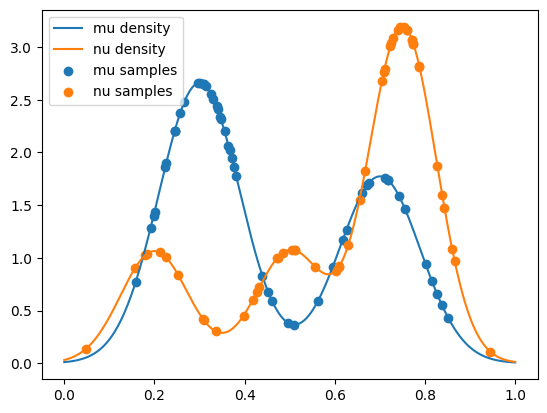

In [314]:
x = np.linspace(0, 1, n)

f, ax = plt.subplots()

ax.plot(x, mu_, label = 'mu density')
ax.plot(x, nu_, label = 'nu density')

ax.scatter(X_, mu_[(n * X_).astype(int)], label = 'mu samples')
ax.scatter(Y, nu_[np.minimum((n * Y).astype(int), n-1)], label = 'nu samples')


plt.legend()
plt.show()

In [315]:
X_fill, Y_fill, sob = fit_points_generation(nfill)

In [316]:
kernel = 'gaussian'
l = 0.1
Phi, M, Kx1, Ky1, Kx2, Ky2, Kx3, Ky3 = make_kernels(X_[:, None], Y[:, None], X_fill, Y_fill, l=l, kernel = kernel)

In [317]:
data = {}
data["Phi"] = Phi
data["KX1"] = Kx1
data["KX2"] = Kx2
data["KX3"] = Kx3
data["KY1"] = Ky1
data["KY2"] = Ky2
data["KY3"] = Ky3
data["M"] = M


In [318]:
## Regularization parameters

lbda_1 = 1 / nfill
lbda_2 =  1 / np.sqrt(nsamples)

In [296]:
### Compute OT from samples
x = np.linspace(0., 1., n)

M_ot = ((x[:, None] - x)**2) / 2
P, log = ot.emd(mu_ / mu_.sum(), nu_ / nu_.sum(), M_ot, log = True)
sampled_ot = (P * M_ot).sum()

In [321]:
gamma, c, t, res_time, res_norm,cpu_time, details, nb_EG_iter = SSN(data, alph_1=1e-6, alph_2=1, beta_0=0.5, beta_1=.9,
                                      beta_2=5, theta_upper=15, theta_lower=1e-16, reg1=lbda_1,
                                      reg2=lbda_2, EG_rate=0.00029, nIter=2800, verbose=False)

<Figure size 640x480 with 0 Axes>

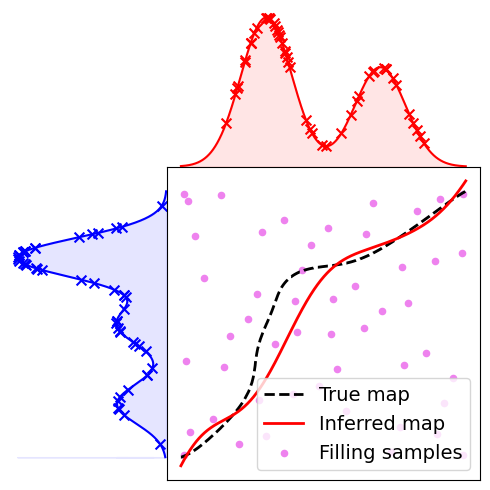

In [322]:
plot_distributions(P, mu_, nu_, transport_1D, gamma, X_, X_fill, lbda_2, kernel, l, sob, n, Y)

#### b) Visualization of the contraints

In [323]:
na, nb = P.shape

xa = np.arange(na)
xb = np.arange(nb)

Txa = np.argmax(P, 1)
x = np.linspace(0, 1, len(xa)) 
TX = transport_1D(x, gamma, X_, X_fill, lbda_2, kernel=kernel, l=l) 

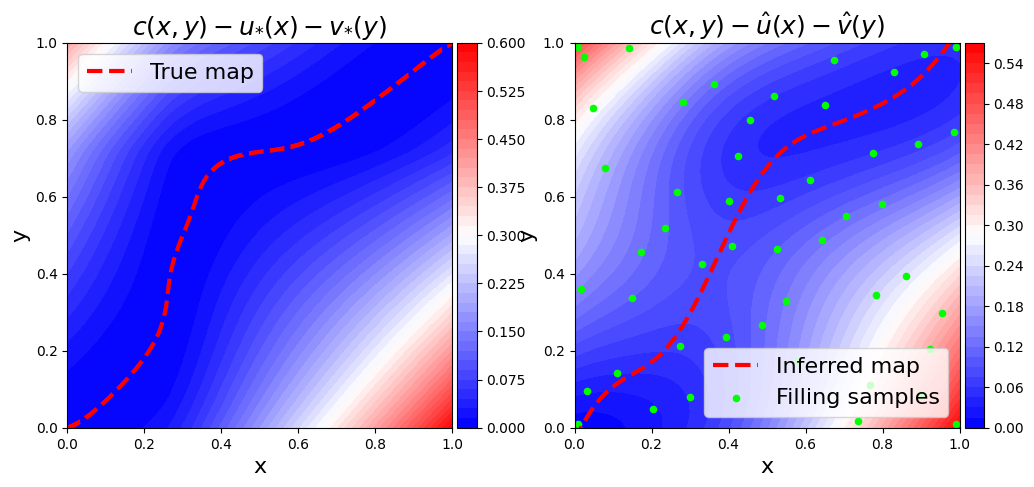

In [324]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

x = np.linspace(0., 1., n)
y = np.linspace(0., 1., n)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax1, ax2 = ax

### True constraint function

#### Compute true function
a = log['u']
b = log['v']

Z = M_ot - a - b[:, None] 


#### Plot
levels = 40
CS = ax1.contour(x, y, Z, levels= levels, colors='none')
CF = ax1.contourf(x, y, Z, levels = levels, cmap = 'bwr')
ax1.plot(x, Txa/na, color = 'r', ls = '--', lw = 3, label = 'True map')

## nice colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(CF, cax=cax)

ax1.set_aspect('equal')
ax1.set_xlabel('x', fontsize = 16)
ax1.set_ylabel('y', fontsize = 16)
ax1.set_title(r'$c(x, y) - u_{*}(x) - v_{*}(y)$', fontsize = 18)
ax1.legend(fontsize = 16)


### Inferred constraint function

#### Compute model
M_ot = ((x[:, None] - y)**2) / 2
u = potential_1D(x[:, None], gamma, X_, X_fill, lbda_2, l, kernel)
v = potential_1D(x[:, None], gamma, Y, Y_fill, lbda_2, l, kernel)
Z = M_ot - u - v[:, None] + 0.27

#### Plot
CS = ax2.contour(x, y, Z, levels= levels,colors='none')
CF = ax2.contourf(x, y, Z, levels = levels, cmap = 'bwr')

ax2.set_aspect('equal')
ax2.plot(xa/ na, TX, color = 'r', lw =3, ls = '--', label = 'Inferred map')
ax2.set_ylim(ymin = 0, ymax=1)
ax2.scatter(X_fill, Y_fill, color = 'lime', s=20, label='Filling samples')

#### nice colorbar
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(CF, cax=cax)

ax2.set_xlabel('x', fontsize = 16)
ax2.set_ylabel('y', fontsize = 16)
ax2.set_title(r'$c(x,y) - \hat{u}(x) - \hat{v}(y)$', fontsize = 18)
ax2.legend(fontsize = 16)


plt.show()

#### c) Estimation of OT map using EG algorithm

In [333]:
gamma, c, t, res_time, res_norm,cpu_time,details = EG(data, reg1=lbda_1, reg2=lbda_2, EG_rate = 0.0006, 
                                                      nIter = 1400, verbose = False)

<Figure size 640x480 with 0 Axes>

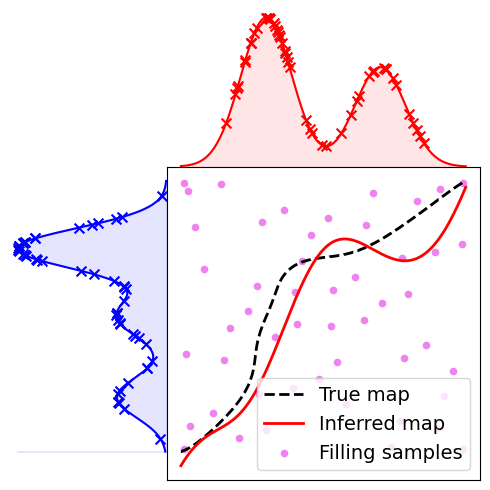

In [334]:
plot_distributions(P, mu_, nu_, transport_1D, gamma, X_, X_fill, lbda_2, kernel, l, sob, n, Y)

#### c) Estimation of OT map using SSN algorithm without EG step

In [335]:
gamma, c, t, res_time, res_norm,cpu_time,details = SSN_without_EG(data, alph_1=1e-6, alph_2=1, beta_0=0.5, beta_1=2,
                                      beta_2=0.5, theta_upper=1, theta_lower=1e-16, reg1=lbda_1,
                                      reg2=lbda_2, nIter=2000, verbose=False)

<Figure size 640x480 with 0 Axes>

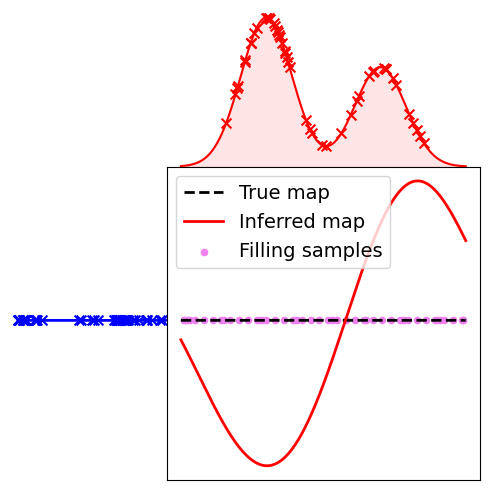

In [336]:
plot_distributions(P, mu_, nu_, transport_1D, gamma, X_, X_fill, lbda_2, kernel, l, sob, n, Y)

#### d) Visualysation of the evolution of the estimated OT map during the optimization

Number of iterations 1
Number of EG steps chosing 1


<Figure size 640x480 with 0 Axes>

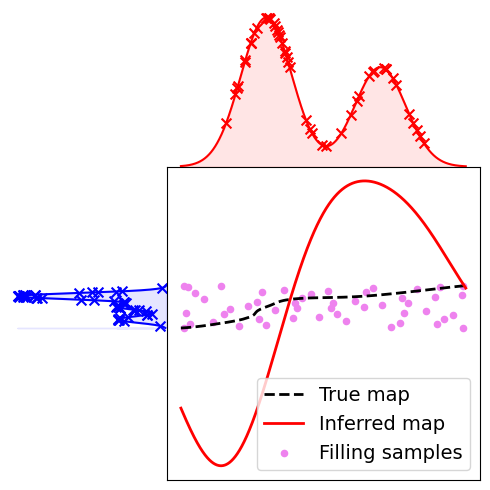

Number of iterations 400
Number of EG steps chosing 395


<Figure size 640x480 with 0 Axes>

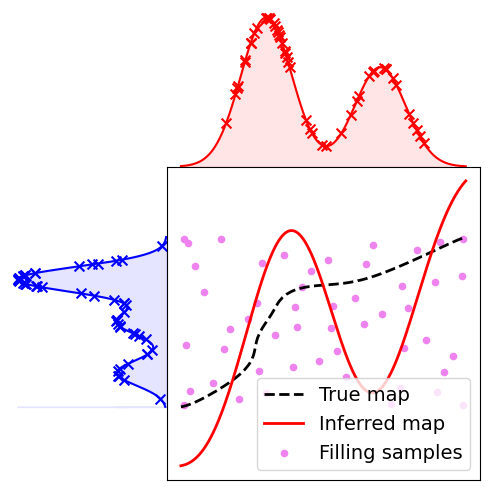

Number of iterations 800
Number of EG steps chosing 795


<Figure size 640x480 with 0 Axes>

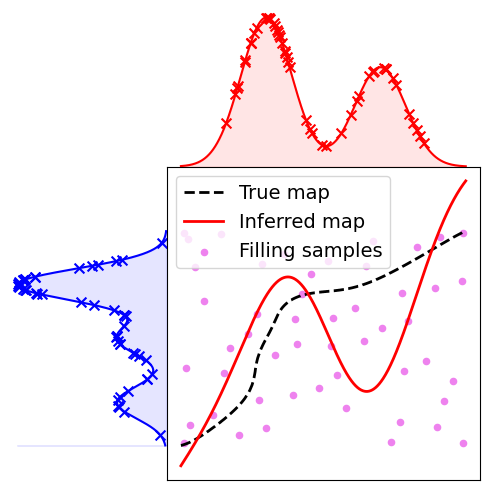

Number of iterations 1200
Number of EG steps chosing 1195


<Figure size 640x480 with 0 Axes>

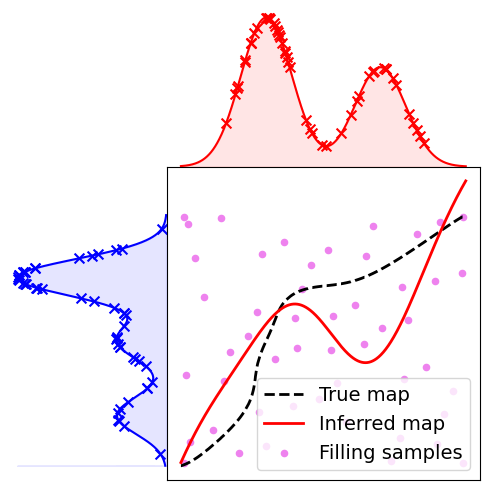

Number of iterations 1600
Number of EG steps chosing 1595


<Figure size 640x480 with 0 Axes>

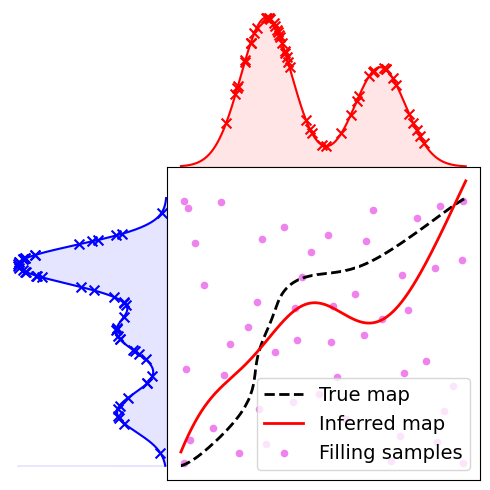

Number of iterations 2000
Number of EG steps chosing 1765


<Figure size 640x480 with 0 Axes>

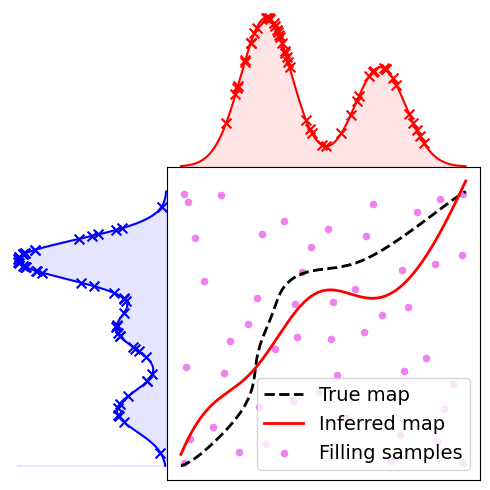

Number of iterations 2400
Number of EG steps chosing 1768


<Figure size 640x480 with 0 Axes>

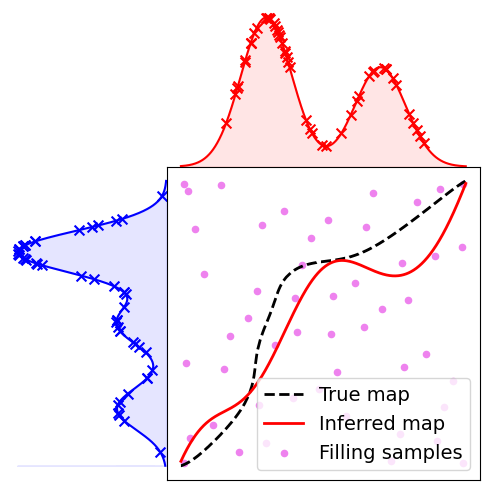

Number of iterations 2800
Number of EG steps chosing 1784


<Figure size 640x480 with 0 Axes>

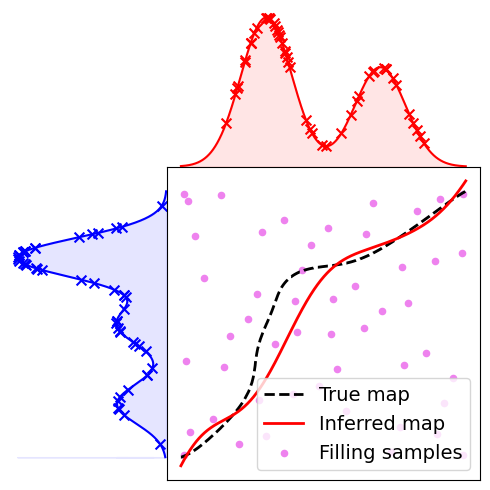

Number of iterations 3000
Number of EG steps chosing 1787


<Figure size 640x480 with 0 Axes>

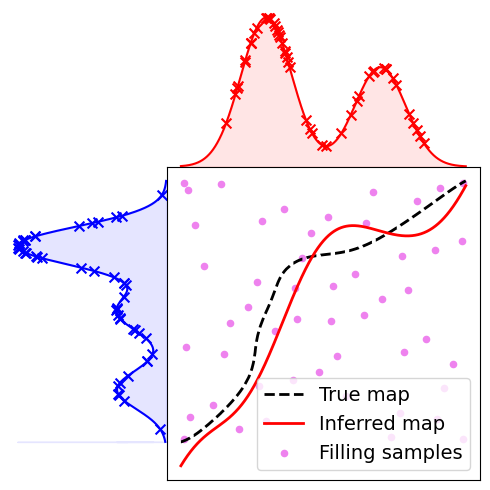

In [340]:
iteration = [1, 400, 800, 1200, 1600, 2000, 2400, 2800, 3000]
nb_EG_iters = []
for it in iteration:
    gamma, c, t, res_time, res_norm,cpu_time, details, nb_EG_iter = SSN(data, alph_1=1e-6, alph_2=1, beta_0=0.5, beta_1=.9,
                                      beta_2=5, theta_upper=15, theta_lower=1e-16, reg1=lbda_1,
                                      reg2=lbda_2, EG_rate=0.00029, nIter=it, verbose=False)
    nb_EG_iters.append(nb_EG_iter)
    print("Number of iterations", it)
    print("Number of EG steps chosing", nb_EG_iter)
    plot_distributions(P, mu_, nu_, transport_1D, gamma, X_, X_fill, lbda_2, kernel, l, sob, n, Y)
     

#### e) Number of EG step used to update w

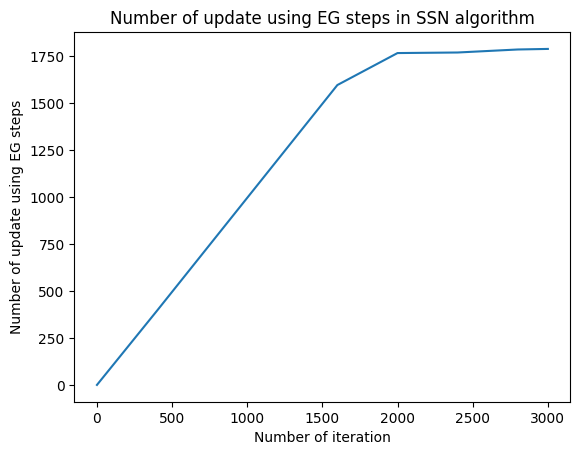

In [344]:
plt.plot(iteration, nb_EG_iters)
plt.xlabel("Number of iteration")
plt.ylabel("Number of update using EG steps")
plt.title("Number of update using EG steps in SSN algorithm")
plt.show()

### 4) Estimation of OT map with nsample = nfill = 100

In [345]:
nfill, nsamples = 100, 100

In [346]:
X_, Y = sample_generation(nsamples, mu1, mu2, t1, t2)

In [347]:
X_fill, Y_fill, sob = fit_points_generation(nfill)

In [348]:
l = 0.09
Phi, M, Kx1, Ky1, Kx2, Ky2, Kx3, Ky3 = make_kernels(X_[:, None], Y[:, None], X_fill, Y_fill, l=l, kernel = kernel)

In [349]:
data = {}
data["Phi"] = Phi
data["KX1"] = Kx1
data["KX2"] = Kx2
data["KX3"] = Kx3
data["KY1"] = Ky1
data["KY2"] = Ky2
data["KY3"] = Ky3
data["M"] = M

In [350]:
lbda_1 = 1 / nfill
lbda_2 =  1 / np.sqrt(nsamples)

In [351]:
gamma, c, t, res_time, res_norm,cpu_time,details, _ = SSN(data, alph_1=1e-6, alph_2=1, beta_0=0.5, beta_1=2,
                                      beta_2=5, theta_upper=15, theta_lower=1e-16, reg1=lbda_1,
                                      reg2=lbda_2, EG_rate=0.0005, nIter=2200, verbose=False)

<Figure size 640x480 with 0 Axes>

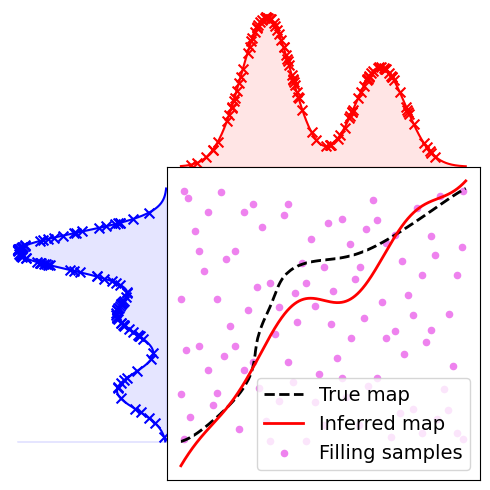

In [352]:
plot_distributions(P, mu_, nu_, transport_1D, gamma, X_, X_fill, lbda_2, kernel, l, sob, n, Y)

### 4) Estimation of OT map with nsample = nfill = 200

In [353]:
nfill = 200
nsamples = 200

In [354]:

X_, Y = sample_generation(nsamples, mu1, mu2, t1, t2)

In [355]:
X_fill, Y_fill, sob = fit_points_generation(nfill)

In [356]:
l = 0.09
Phi, M, Kx1, Ky1, Kx2, Ky2, Kx3, Ky3 = make_kernels(X_[:, None], Y[:, None], X_fill, Y_fill, l=l, kernel = kernel)

In [357]:
data = {}
data["Phi"] = Phi
data["KX1"] = Kx1
data["KX2"] = Kx2
data["KX3"] = Kx3
data["KY1"] = Ky1
data["KY2"] = Ky2
data["KY3"] = Ky3
data["M"] = M

In [358]:
lbda_1 = 1 / nfill
lbda_2 =  1 / np.sqrt(nsamples)

In [359]:
gamma, c, t, res_time, res_norm,cpu_time,details, _ = SSN(data, alph_1=1e-6, alph_2=1, beta_0=0.5, beta_1=2,
                                      beta_2=5, theta_upper=15, theta_lower=1e-16, reg1=lbda_1,
                                      reg2=lbda_2, EG_rate=0.0007, nIter=1800, verbose=False)

<Figure size 640x480 with 0 Axes>

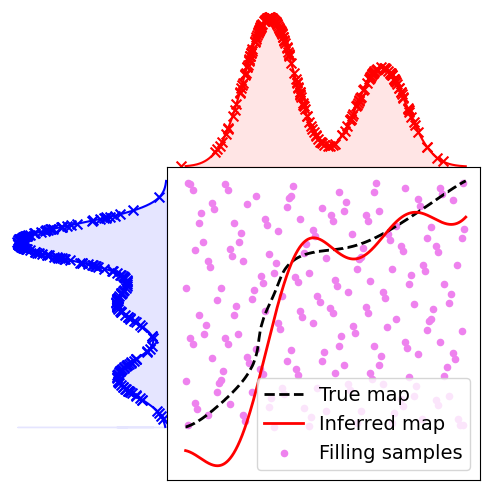

In [360]:
plot_distributions(P, mu_, nu_, transport_1D, gamma, X_, X_fill, lbda_2, kernel, l, sob, n, Y)